In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
pd.options.mode.chained_assignment = None 
import copy
from scipy.stats import norm
import random
from multiprocessing import Pool

In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/alex/transport/TransportNet/Stable Dynamic & Beckman/model.py'>

In [3]:
import numba
numba.__version__

'0.54.1'

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/alex/transport/env/bin/python3
3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
python 3.8.10
numpy 1.17.4
pandas 1.3.4
graph_tool 2.43 (commit 9d41331e, Wed Jul 7 15:32:52 2021 +0200)


# Beckmann model

parameter $\mu = 0.25$

In [5]:
beckmann_save = 'beckmann_results/'

In [13]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

initial_model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


In [7]:
def node_roads(graph_table, node):
    return set(graph_table[np.array(graph_table['term_node'] == node) + np.array(graph_table['init_node'] == node)].index)


def edge_neighbours(graph_table, edge_num):
    init_node = graph_table.loc[edge_num]['init_node']
    term_node = graph_table.loc[edge_num]['term_node']
    res = node_roads(graph_table, init_node)
    res.update(node_roads(graph_table, term_node))
    return res

def n_neighbour_edges(graph_table, node, depth):
    neighbours = node_roads(graph_table, node)
    for i in range(depth - 1):
        new_neighbours = neighbours.copy()
        for curr_edge in neighbours:
            new_neighbours.update(edge_neighbours(graph_table, curr_edge))
        neighbours = new_neighbours
    return neighbours


def normal_distribution_noise(graph_data, graph_correspondences, node, depth, std_percentage_capacity, std_percentage_flow):
    graph_data_copy = copy.deepcopy(graph_data)
    graph_correspondences_copy = copy.deepcopy(graph_correspondences)
    graph_capacity = graph_data_copy['graph_table']['capacity']
    graph_free_flow_time = graph_data_copy['graph_table']['free_flow_time']

    graph_table = graph_data['graph_table']
    neighbour_edges = n_neighbour_edges(graph_table, node, depth)

    for index in neighbour_edges:
        capacity = graph_capacity[index]
        std = capacity * std_percentage_capacity
        noise = norm.rvs(0, std)
        graph_capacity[index] = max(capacity + noise, 0.1)

        flow = graph_free_flow_time[index]
        std = flow * std_percentage_flow
        noise = norm.rvs(0, std)
        graph_free_flow_time[index] = max(flow + noise, 0.1)
    return graph_data_copy, graph_correspondences_copy

### Universal Similar Triangles

In [26]:
import multiprocessing
multiprocessing.cpu_count()


8

In [45]:
def compute(kwargs):
    # для инита можно просто передать depth = 0.
    tic = time.time()
    model = kwargs['model']
    rep = kwargs['repeat']
    depth = kwargs['depth']
    
    solver_kwargs = kwargs['solver_kwargs']
    if "t_start" in kwargs:
        result = model.find_equilibrium(solver_name = kwargs['solver_name'], t_start=kwargs['t_start'], composite=True, solver_kwargs = solver_kwargs)
    else:
        result = model.find_equilibrium(solver_name = kwargs['solver_name'], composite=True, solver_kwargs = solver_kwargs)
    toc = time.time()
    result['eps_abs'] = solver_kwargs['eps_abs']
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'var_depth_' + str(depth) + '_rep_' + str(rep) + '_' + kwargs['solver_name'] + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)
    return {'args': kwargs, 'result': result, 'time': toc - tic}

def find_eq_for_list(arg_list):# передавать список моделей тоже, что-ли? нет, одну модель. 
    # Пусть все считаются на одной модели
    pool = Pool(processes=len(arg_list))
    return pool.map(compute, arg_list)

In [47]:
solvers = ['ustm', 'fwm', 'ugd', 'wda', 'sd']

# we compute start point
assert(model.mu == 0.25)
max_iter = 20000
#for index, eps_abs in enumerate(epsilons):
#if index < len(epsilons) - 1:
#    continue
#epsilons = np.logspace(3,-0.5,8)
eps_abs = 10 #epsilons[5] # при таком эпсилоне начальная точка считается 300 секунд здесь.
print('eps_abs =', eps_abs)
solver_kwargs = {'eps_abs': eps_abs,
                 'max_iter': max_iter, 'stop_crit': 'dual_gap',
                 'verbose' : True, 'verbose_step': 1000, 'save_history' : True, 'times_flows_save_step' : 100}
tic = time.time()
result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['eps_abs'] = eps_abs
result['elapsed_time'] = toc - tic
with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(eps_abs) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

old_result = result.copy()

In [39]:
num_repeats = 10
depths_range = range(1,6)
std_percentage_capacity = 0.2
std_percentage_flow = 0.2
max_iter = 20000
eps_abs = 10

In [48]:
arg_list = []
#solvers = ['ustm']
for solver_name in solvers:
    print("SOLVER - ", solver_name)
    result_for_solver = []
    kwargs = {'solver_name': solver_name, 'model': initial_model, 'repeat': 0, 'depth': 0}
    solver_kwargs = {'eps_abs': eps_abs,
             'max_iter': max_iter, 'stop_crit': 'dual_gap',
             'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    kwargs['solver_kwargs'] = solver_kwargs
    arg_list.append(kwargs)

initial_results = find_eq_for_list(arg_list)

SOLVER -  ustm
SOLVER -  fwm
SOLVER -  ugd
SOLVER -  wda
SOLVER -  sd
Oracles created...
Frank-Wolfe method...
Composite optimization...
Oracles created...Composite optimization...Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4


Universal similar triangles method...Composite optimization...Oracles created...Composite optimization...
Oracles created...



Subgradient descent method...
Universal gradient descent method...Oracles created...

Weighted dual averages method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4


Result: success
Total iters: 161
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.98425
Duality_gap / Duality_gap_init = 0.000208294
Oracle elapsed ti

In [44]:
initial_results[0]['result']['times']

array([1.15275151, 1.30642844, 1.17640524, 1.63182692, 1.0915746 ,
       1.13699282, 1.15496705, 1.00004796, 1.00035358, 1.00021332,
       1.        , 1.00000001, 1.00000983, 1.00001002, 1.        ,
       1.00000004, 1.00000485, 1.00000068, 1.00003116, 1.00402416,
       1.00003839, 1.00005489, 1.00000127, 1.00001135, 1.00067015,
       1.00042467, 1.00002571, 1.00011935, 1.00094764, 0.14906832,
       0.14906832, 0.14949881, 0.14926542, 0.14911274, 0.14906833,
       0.14906833, 0.14906833, 0.14907264, 0.14906844, 0.14906857,
       0.14906835, 0.14907777, 0.14906976, 0.14907362, 0.14908478,
       0.14907168, 0.14906849, 0.14906869, 0.14906915, 0.14927558,
       0.14907186, 0.14907317, 0.14906835, 0.14906844, 0.14906833,
       0.14906833, 0.14906832, 0.14906834, 0.14906994, 1.45984849,
       1.45984849, 1.32007576, 1.32007576, 1.0000024 , 1.        ,
       1.00000386, 1.00000071, 1.54015152, 1.54015152, 1.00000043,
       3.        , 1.        , 1.        , 1.00000185, 1.00005

In [49]:
node = random.randint(1, graph_data['nodes number']) # maybe fix one node for all time
for depth in depths_range:
    print("SOLVER - ", solver_name)
    for repeat in range(num_repeats):
        new_graph_data, new_graph_correspondences = normal_distribution_noise(graph_data, graph_correspondences, node, depth, std_percentage_capacity, std_percentage_flow)
        new_model = md.Model(new_graph_data, new_graph_correspondences, 
                        total_od_flow, mu = 0.25, rho = 0.15)
        arg_list = []
        for i, solver_name in enumerate(solvers):
            # вот тут надо передать точку старта, куда сошелся этот методи
            kwargs = {'solver_name': solver_name, "t_start": initial_results[i]['result']['times'], 'model': new_model, 'repeat': repeat, 'depth': depth}
            solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
            kwargs['solver_kwargs'] = solver_kwargs
            arg_list.append(kwargs)
        this_repeat_results = find_eq_for_list(arg_list)

SOLVER -  sd
Oracles created...
Frank-Wolfe method...Composite optimization...

Composite optimization...Oracles created...

Oracles created...
Universal gradient descent method...Weighted dual averages method...

Composite optimization...
Primal_init = 1.28636e+06
Dual_init = -1.28546e+06
Duality_gap_init = 901.019Oracles created...

Composite optimization...Universal similar triangles method...

Oracles created...Primal_init = 1.28648e+06
Dual_init = -1.28533e+06
Duality_gap_init = 1145.48

Primal_init = 1.28637e+06
Dual_init = -1.28546e+06
Duality_gap_init = 911.037Subgradient descent method...

Primal_init = 1.28636e+06
Dual_init = -1.28546e+06
Duality_gap_init = 895.314
Primal_init = 1.29236e+06
Dual_init = -1.26211e+06
Duality_gap_init = 30252.1

Result: success
Total iters: 122
Primal_func_value = 1.2862e+06
Dual_func_value = -1.28619e+06
Duality_gap = 9.85973
Duality_gap / Duality_gap_init = 0.0109429
Oracle elapsed time: 3 sec

Result: success
Total iters: 163
Primal_func_valu

Duality_gap / Duality_gap_init = 0.0184114

Result: success
Total iters: 11172
Primal_func_value = 1.28657e+06
Dual_func_value = -1.28656e+06
Duality_gap = 9.99977
Duality_gap / Duality_gap_init = 0.0153189
Oracle elapsed time: 656 sec
Composite optimization...
Oracles created...
Universal similar triangles method...Composite optimization...

Composite optimization...
Oracles created...Oracles created...

Universal gradient descent method...
Subgradient descent method...
Primal_init = 1.28497e+06
Dual_init = -1.28417e+06
Duality_gap_init = 802.879Oracles created...

Composite optimization...Frank-Wolfe method...

Oracles created...
Primal_init = 1.28509e+06
Dual_init = -1.28404e+06
Duality_gap_init = 1053.33Weighted dual averages method...

Primal_init = 1.29103e+06
Dual_init = -1.26106e+06
Duality_gap_init = 29967.9
Primal_init = 1.28498e+06
Dual_init = -1.28416e+06
Duality_gap_init = 815.223
Primal_init = 1.28499e+06
Dual_init = -1.28417e+06
Duality_gap_init = 819.428

Result: succes

Duality_gap / Duality_gap_init = 0.754277

Iterations number: 16000
Primal_func_value = 1.28559e+06
Dual_func_value = -1.26163e+06
Duality_gap = 23960.9
Duality_gap / Duality_gap_init = 0.7334

Iterations number: 18000
Primal_func_value = 1.28545e+06
Dual_func_value = -1.26209e+06
Duality_gap = 23362.2
Duality_gap / Duality_gap_init = 0.715076

Iterations number: 8000
Inner iterations number: 16002
Primal_func_value = 1.28205e+06
Dual_func_value = -1.28195e+06
Duality_gap = 100.188
Duality_gap / Duality_gap_init = 0.0246844

Iterations number: 20000
Primal_func_value = 1.28536e+06
Dual_func_value = -1.26254e+06
Duality_gap = 22821.1
Duality_gap / Duality_gap_init = 0.698514

Result: iterations number exceeded
Total iters: 20000
Primal_func_value = 1.28536e+06
Dual_func_value = -1.26254e+06
Duality_gap = 22821.1
Duality_gap / Duality_gap_init = 0.698514
Oracle elapsed time: 520 sec

Iterations number: 10000
Inner iterations number: 20002
Primal_func_value = 1.28204e+06
Dual_func_value =

Duality_gap / Duality_gap_init = 0.881829

Iterations number: 8000
Primal_func_value = 1.28923e+06
Dual_func_value = -1.26426e+06
Duality_gap = 24962.4
Duality_gap / Duality_gap_init = 0.84406

Iterations number: 4000
Inner iterations number: 8003
Primal_func_value = 1.28489e+06
Dual_func_value = -1.28482e+06
Duality_gap = 71.274
Duality_gap / Duality_gap_init = 0.122385

Iterations number: 10000
Primal_func_value = 1.28885e+06
Dual_func_value = -1.26481e+06
Duality_gap = 24038.2
Duality_gap / Duality_gap_init = 0.812813

Iterations number: 12000
Primal_func_value = 1.2886e+06
Dual_func_value = -1.26531e+06
Duality_gap = 23292.3
Duality_gap / Duality_gap_init = 0.78759

Iterations number: 6000
Inner iterations number: 12003
Primal_func_value = 1.28489e+06
Dual_func_value = -1.28484e+06
Duality_gap = 49.7185
Duality_gap / Duality_gap_init = 0.085372

Iterations number: 14000
Primal_func_value = 1.2884e+06
Dual_func_value = -1.26579e+06
Duality_gap = 22616.3
Duality_gap / Duality_gap_ini

Duality_gap / Duality_gap_init = 0.01722
Oracle elapsed time: 6 sec

Result: success
Total iters: 400
Primal_func_value = 1.28575e+06
Dual_func_value = -1.28574e+06
Duality_gap = 9.99866
Duality_gap / Duality_gap_init = 0.0177186
Oracle elapsed time: 22 sec

Iterations number: 2000
Primal_func_value = 1.29149e+06
Dual_func_value = -1.26296e+06
Duality_gap = 28529.7
Duality_gap / Duality_gap_init = 0.956437

Iterations number: 4000
Primal_func_value = 1.29114e+06
Dual_func_value = -1.26367e+06
Duality_gap = 27473.5
Duality_gap / Duality_gap_init = 0.921028

Iterations number: 2000
Inner iterations number: 4001
Primal_func_value = 1.28577e+06
Dual_func_value = -1.28568e+06
Duality_gap = 96.7377
Duality_gap / Duality_gap_init = 0.118756

Iterations number: 6000
Primal_func_value = 1.2906e+06
Dual_func_value = -1.26431e+06
Duality_gap = 26285.1
Duality_gap / Duality_gap_init = 0.881189

Iterations number: 8000
Primal_func_value = 1.29012e+06
Dual_func_value = -1.26492e+06
Duality_gap = 252

Duality_gap_init = 883.205Primal_init = 1.28609e+06
Dual_init = -1.28523e+06
Duality_gap_init = 867.335

Primal_init = 1.29202e+06
Dual_init = -1.26188e+06
Duality_gap_init = 30140.1

Result: success
Total iters: 95
Primal_func_value = 1.28596e+06
Dual_func_value = -1.28595e+06
Duality_gap = 9.99973
Duality_gap / Duality_gap_init = 0.0114394
Oracle elapsed time: 2 sec

Result: success
Total iters: 216
Primal_func_value = 1.28596e+06
Dual_func_value = -1.28595e+06
Duality_gap = 9.975
Duality_gap / Duality_gap_init = 0.0112941
Oracle elapsed time: 6 sec

Result: success
Total iters: 486
Primal_func_value = 1.28596e+06
Dual_func_value = -1.28595e+06
Duality_gap = 9.98868
Duality_gap / Duality_gap_init = 0.0115165
Oracle elapsed time: 27 sec

Iterations number: 2000
Primal_func_value = 1.29157e+06
Dual_func_value = -1.26273e+06
Duality_gap = 28833.1
Duality_gap / Duality_gap_init = 0.956635

Iterations number: 4000
Primal_func_value = 1.29122e+06
Dual_func_value = -1.26344e+06
Duality_gap 

Oracles created...Universal similar triangles method...

Frank-Wolfe method...
Composite optimization...
Oracles created...Primal_init = 1.28711e+06
Dual_init = -1.28439e+06
Duality_gap_init = 2716.91Composite optimization...

Oracles created...

Universal gradient descent method...Composite optimization...Weighted dual averages method...

Primal_init = 1.28712e+06
Dual_init = -1.2844e+06
Duality_gap_init = 2716.22

Oracles created...
Subgradient descent method...
Primal_init = 1.28723e+06
Dual_init = -1.28426e+06
Duality_gap_init = 2968.78
Primal_init = 1.28712e+06
Dual_init = -1.28439e+06
Duality_gap_init = 2731.81
Primal_init = 1.29308e+06
Dual_init = -1.2608e+06
Duality_gap_init = 32277.8

Result: success
Total iters: 119
Primal_func_value = 1.28695e+06
Dual_func_value = -1.28694e+06
Duality_gap = 9.93124
Duality_gap / Duality_gap_init = 0.00365627
Oracle elapsed time: 3 sec

Result: success
Total iters: 157
Primal_func_value = 1.28695e+06
Dual_func_value = -1.28694e+06
Duality_gap

Duality_gap / Duality_gap_init = 0.677368
Oracle elapsed time: 518 sec

Iterations number: 10000
Inner iterations number: 20002
Primal_func_value = 1.28534e+06
Dual_func_value = -1.28531e+06
Duality_gap = 31.0846
Duality_gap / Duality_gap_init = 0.0156798

Iterations number: 12000
Inner iterations number: 24001
Primal_func_value = 1.28534e+06
Dual_func_value = -1.28532e+06
Duality_gap = 24.2304
Duality_gap / Duality_gap_init = 0.0122224

Iterations number: 14000
Inner iterations number: 28003
Primal_func_value = 1.28534e+06
Dual_func_value = -1.28532e+06
Duality_gap = 19.4021
Duality_gap / Duality_gap_init = 0.00978692

Iterations number: 16000
Inner iterations number: 32003
Primal_func_value = 1.28534e+06
Dual_func_value = -1.28532e+06
Duality_gap = 15.8088
Duality_gap / Duality_gap_init = 0.00797436

Iterations number: 18000
Inner iterations number: 36002
Primal_func_value = 1.28534e+06
Dual_func_value = -1.28532e+06
Duality_gap = 13.1247
Duality_gap / Duality_gap_init = 0.00662045



Inner iterations number: 12001
Primal_func_value = 1.28672e+06
Dual_func_value = -1.2867e+06
Duality_gap = 25.9826
Duality_gap / Duality_gap_init = 0.0201247

Iterations number: 14000
Primal_func_value = 1.29055e+06
Dual_func_value = -1.26754e+06
Duality_gap = 23005.4
Duality_gap / Duality_gap_init = 0.757092

Iterations number: 16000
Primal_func_value = 1.29031e+06
Dual_func_value = -1.26799e+06
Duality_gap = 22317.3
Duality_gap / Duality_gap_init = 0.734447

Iterations number: 18000
Primal_func_value = 1.29012e+06
Dual_func_value = -1.26842e+06
Duality_gap = 21704.1
Duality_gap / Duality_gap_init = 0.714266

Iterations number: 8000
Inner iterations number: 16001
Primal_func_value = 1.28672e+06
Dual_func_value = -1.2867e+06
Duality_gap = 17.1295
Duality_gap / Duality_gap_init = 0.0132676

Iterations number: 20000
Primal_func_value = 1.28997e+06
Dual_func_value = -1.26882e+06
Duality_gap = 21154.5
Duality_gap / Duality_gap_init = 0.696181

Result: iterations number exceeded
Total iters

Iterations number: 10000
Primal_func_value = 1.29362e+06
Dual_func_value = -1.26927e+06
Duality_gap = 24349
Duality_gap / Duality_gap_init = 0.736104

Iterations number: 12000
Primal_func_value = 1.29344e+06
Dual_func_value = -1.2698e+06
Duality_gap = 23642.8
Duality_gap / Duality_gap_init = 0.714754

Iterations number: 6000
Inner iterations number: 12002
Primal_func_value = 1.28961e+06
Dual_func_value = -1.28958e+06
Duality_gap = 25.8751
Duality_gap / Duality_gap_init = 0.00723811

Iterations number: 14000
Primal_func_value = 1.2933e+06
Dual_func_value = -1.27028e+06
Duality_gap = 23019.7
Duality_gap / Duality_gap_init = 0.695917

Iterations number: 16000
Primal_func_value = 1.29313e+06
Dual_func_value = -1.27074e+06
Duality_gap = 22393
Duality_gap / Duality_gap_init = 0.676972

Iterations number: 18000
Primal_func_value = 1.293e+06
Dual_func_value = -1.27117e+06
Duality_gap = 21833.1
Duality_gap / Duality_gap_init = 0.660045

Iterations number: 8000
Inner iterations number: 16001
Pri

Duality_gap / Duality_gap_init = 0.00437463
Oracle elapsed time: 20 sec

Iterations number: 2000
Primal_func_value = 1.29321e+06
Dual_func_value = -1.26437e+06
Duality_gap = 28841.4
Duality_gap / Duality_gap_init = 0.903648

Iterations number: 4000
Primal_func_value = 1.29286e+06
Dual_func_value = -1.26512e+06
Duality_gap = 27735.8
Duality_gap / Duality_gap_init = 0.869006

Iterations number: 2000
Inner iterations number: 4001
Primal_func_value = 1.28759e+06
Dual_func_value = -1.28751e+06
Duality_gap = 85.1599
Duality_gap / Duality_gap_init = 0.0337752

Iterations number: 6000
Primal_func_value = 1.29234e+06
Dual_func_value = -1.26581e+06
Duality_gap = 26524.8
Duality_gap / Duality_gap_init = 0.831065

Iterations number: 8000
Primal_func_value = 1.29196e+06
Dual_func_value = -1.26645e+06
Duality_gap = 25514.5
Duality_gap / Duality_gap_init = 0.79941

Iterations number: 4000
Inner iterations number: 8002
Primal_func_value = 1.28758e+06
Dual_func_value = -1.28754e+06
Duality_gap = 44.521

Oracles created...
Weighted dual averages method...

Composite optimization...Primal_init = 1.28849e+06
Dual_init = -1.28175e+06
Duality_gap_init = 6733.42

Oracles created...Composite optimization...
Universal gradient descent method...Primal_init = 1.2885e+06
Dual_init = -1.28175e+06
Duality_gap_init = 6747.14


Primal_init = 1.28849e+06
Dual_init = -1.28176e+06
Duality_gap_init = 6730.69
Oracles created...
Subgradient descent method...
Primal_init = 1.28861e+06
Dual_init = -1.28162e+06
Duality_gap_init = 6981.67
Primal_init = 1.29448e+06
Dual_init = -1.25822e+06
Duality_gap_init = 36260.9

Result: success
Total iters: 91
Primal_func_value = 1.28821e+06
Dual_func_value = -1.2882e+06
Duality_gap = 9.95444
Duality_gap / Duality_gap_init = 0.00147896
Oracle elapsed time: 2 sec

Result: success
Total iters: 107
Primal_func_value = 1.28821e+06
Dual_func_value = -1.2882e+06
Duality_gap = 9.9844
Duality_gap / Duality_gap_init = 0.0014798
Oracle elapsed time: 3 sec

Result: success
Total ite

Process ForkPoolWorker-195:
Process ForkPoolWorker-193:
Process ForkPoolWorker-196:
Process ForkPoolWorker-192:
Process ForkPoolWorker-194:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in

#### брать по 5 повторений на каждой ноде, все методы видят одни те же графы. Можно как у Денчика сравнить с initial из free flow (относительное по числу итераций). Наверное имеет смыслл взять eps = 10. распараллелить. Какие методы? В идале все, но так - wda и ustm. Франк Вульф должен всегда работать одинаково. * для каждого прогона построить график расстояния от variance (далеко старая точка от новой?) (какая норма?) (какие асимптотики у 

for depth in depths_range:
    #for rep in range(num_repeats):
        node = random.randint(1, graph_data['nodes number'])
        print(node)
        new_graph_data, new_graph_correspondences = normal_distribution_noise(graph_data, graph_correspondences, node, depth, std_percentage_capacity, std_percentage_flow)
        new_model = md.Model(new_graph_data, new_graph_correspondences, 
                        total_od_flow, mu = 0.25, rho = 0.15)
        # эпсилон фиксируем какой-то один?
        solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 500, 'save_history' : True}
        tic = time.time()
        result = new_model.find_equilibrium(t_start = old_result['times'],solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))
        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

        result['eps_abs'] = eps_abs
        result['depth'] = depth
        result['repetition'] = rep
        result['elapsed_time'] = toc - tic
        with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_depth_' + str(depth) + "_rep_" + str(rep) + '_beckmann.pickle', 'wb') as f:
            pickle.dump(result, f)

In [22]:
# очень большой разброс. Наверное, зависит от выбора точки возмущения - стоит попробовать не дергать ее каждую итерацию.
# может быть, варьировать тоже не надо каждый раз. Надо попробовать построить график, если будет примерно монотонно расти
# от глубины - значит, примерно нормас.

1
2
3
4


In [26]:
results = {}

for method in ['ustm']:
    results[method] = {}
    
    for depth in depths_range:
        results[method][str(depth)] = {}
        results[method][str(depth)]['iters'] = []
        results[method][str(depth)]['inner_iters'] = []
        results[method][str(depth)]['epsilon'] = []
        results[method][str(depth)]['dual_gap_init'] = []
        results[method][str(depth)]['depth'] = []
        i = 0
        while True:
            try:
                with open(beckmann_save + 'anaheim_result_' + method + '_depth_' + str(depth) + "_rep_" + str(i) +'_beckmann.pickle', 'rb') as f:
                    result = pickle.load(f)
                    results[method][str(depth)]['epsilon'].append(result['eps_abs'])
                    results[method][str(depth)]['iters'].append(result['iter_num'])
                    results[method][str(depth)]['depth'].append(result['depth'])
                    results[method][str(depth)]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                    results[method][str(depth)]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
            except FileNotFoundError:
                break
            i += 1


In [27]:
results

{'ustm': {'1': {'iters': [263, 535, 39, 53, 759, 783, 20, 950, 822, 720],
   'inner_iters': [535, 1078, 86, 111, 1526, 1572, 47, 1907, 1651, 1448],
   'epsilon': [3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795],
   'dual_gap_init': [541.8087789649144,
    612.5451553363819,
    610.2256060692016,
    536.3693289319053,
    1064.312712538056,
    826.411552364938,
    544.2406425117515,
    600.4854260131251,
    1036.6417557471432,
    575.5442046578974],
   'depth': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
  '2': {'iters': [990, 440, 1318, 411, 1132, 404, 826, 1619, 1299, 1685],
   'inner_iters': [1986, 888, 2643, 830, 2270, 818, 1659, 3244, 2606, 3377],
   'epsilon': [3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
 

In [28]:
avg_iters = []
avg_inner_iters = []
depths = []
for method in results.keys():
    for depth in results[method].keys():
        print(depth)
        depths.append(int(depth))
        avg_iters.append(np.mean(results[method][depth]['iters']))
        avg_inner_iters.append(np.mean(results[method][depth]['inner_iters']))       

1
2
3
4
5


In [29]:
avg_iters

[494.4, 1012.4, 1617.9, 1394.6, 1769.1]

In [30]:
avg_inner_iters

[996.1, 2032.1, 3241.3, 2794.2, 3543.2]

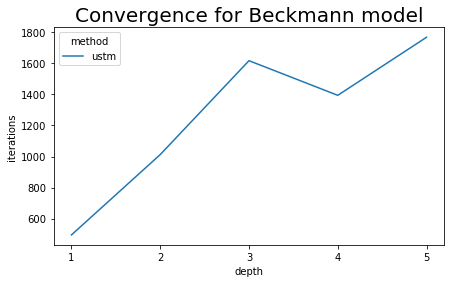

In [33]:
plt.figure(figsize=(7,4))
plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = depths
    y = np.array(avg_iters)
    
    plt.plot(x, y, label = method)
plt.legend(title = 'method')
plt.xticks(x)
plt.xlabel(r'depth')
plt.ylabel('iterations')
plt.show()

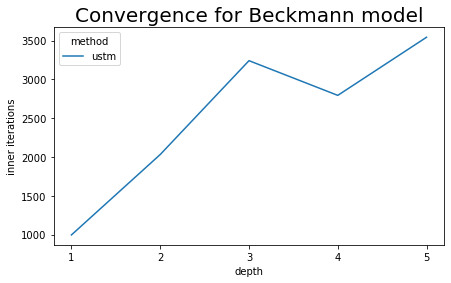

In [34]:
plt.figure(figsize=(7,4))
plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = depths
    y = np.array(avg_inner_iters)
    
    plt.plot(x, y, label = method)
plt.legend(title = 'method')
plt.xticks(x)
plt.xlabel(r'depth')
plt.ylabel('inner iterations')
plt.show()